## Import Dependencies

In [537]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

# format col names to lower & replace whitespaces
def format_col_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ","_")
    return df

## Collect Data

In [538]:
df = pd.read_csv("50_Startups.csv")
df = format_col_names(df)
df.head()

,r&d_spend,administration,marketing_spend,state,profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   r&d_spend        50 non-null     float64
 1   administration   50 non-null     float64
 2   marketing_spend  50 non-null     float64
 3   state            50 non-null     object 
 4   profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


_Here we can see that there are no-NaN values so we can ignore treating Missing Values in the Data Preprocessing section below_

In [540]:
df.isnull().sum()

r&d_spend          0
administration     0
marketing_spend    0
state              0
profit             0
dtype: int64

In [541]:
df.describe()

,r&d_spend,administration,marketing_spend,profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


## Exploratory Data Analysis

#### Univariate Analysis

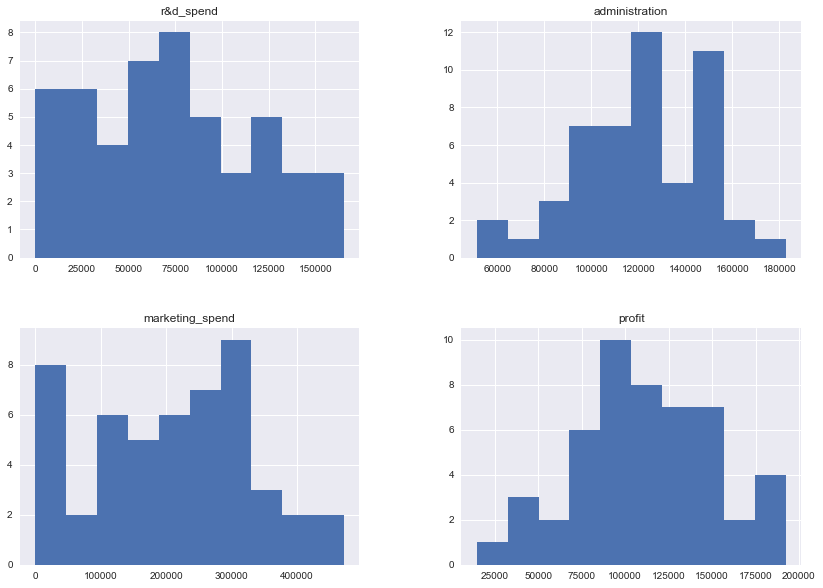

In [542]:
# drop categorical variables for histograms
df_hist = df.copy()
df_hist = df_hist.drop(["state"], axis=1)
df_hist.hist(bins=10, figsize=(14,10))
plt.show()

_Features don't show a normal distribution (to consider: there are only 50 rows so this makes it harder)_

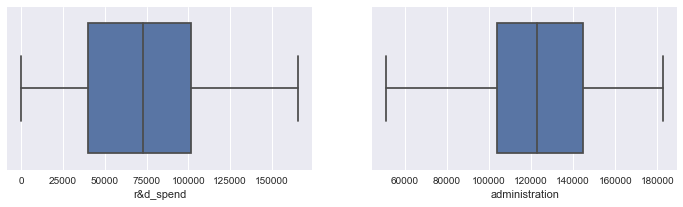

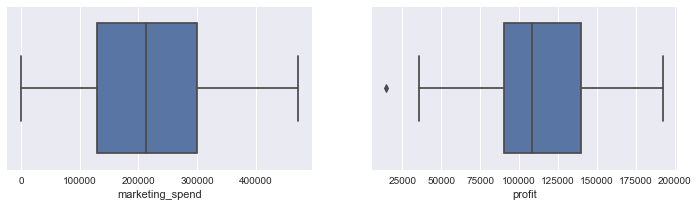

In [543]:
num_attr = ['r&d_spend','administration','marketing_spend','profit']

i = 0
while i < 4:
    fig = plt.figure(figsize=[12,3])

    plt.subplot(1,2,1)
    sns.boxplot(x=num_attr[i], data=df)
    i += 1

    plt.subplot(1,2,2)
    sns.boxplot(x=num_attr[i], data=df)
    i += 1

    plt.show()

_Looking at boxplots there seems to not too many outliers_

#### Multivariate Analysis

<AxesSubplot:xlabel='state', ylabel='count'>

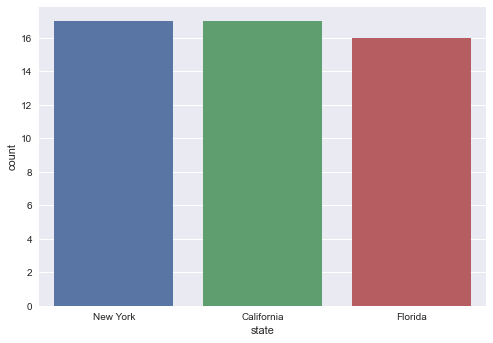

In [544]:
sns.countplot(x = 'state', data = df)

<AxesSubplot:xlabel='state', ylabel='administration'>

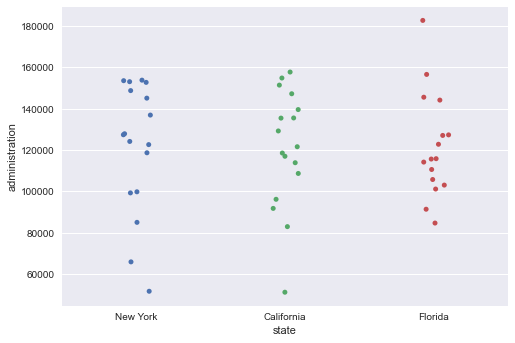

In [545]:
sns.stripplot(x="state", y="administration", data=df)

<AxesSubplot:xlabel='state', ylabel='marketing_spend'>

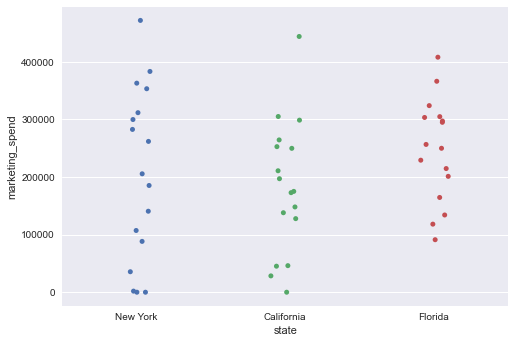

In [546]:
sns.stripplot(x="state", y="marketing_spend", data=df)

<AxesSubplot:xlabel='state', ylabel='r&d_spend'>

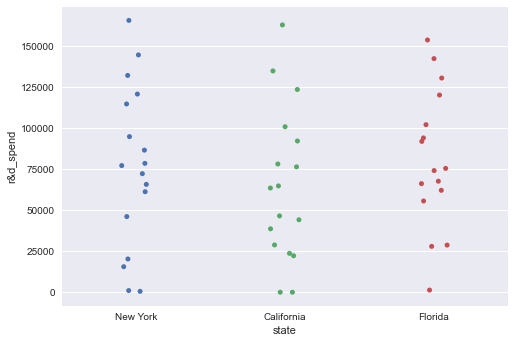

In [547]:
sns.stripplot(x="state", y="r&d_spend", data=df)

<AxesSubplot:xlabel='state', ylabel='profit'>

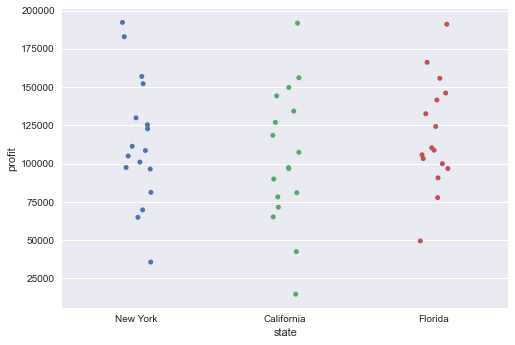

In [548]:
sns.stripplot(x="state", y="profit", data=df)

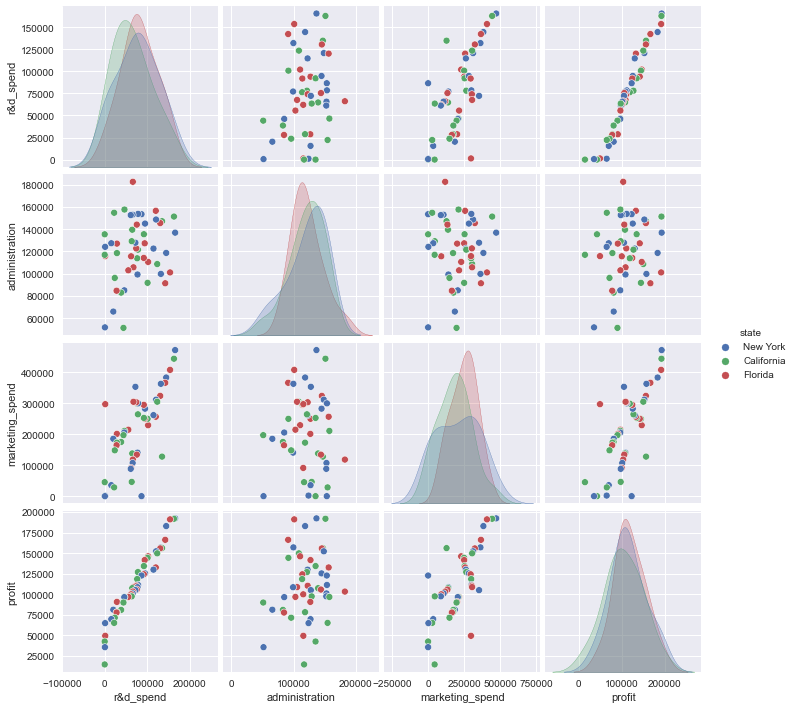

In [549]:
sns.pairplot(df, hue='state')

_Looking at the feature pairplot per state, these don't show any correlation patterns individually_

## Data Preprocessing

#### Feature Encoding

In [550]:
df = format_col_names(pd.get_dummies(df, columns=['state']))
df.head()

,r&d_spend,administration,marketing_spend,profit,state_california,state_florida,state_new_york
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


#### Feature Correlation

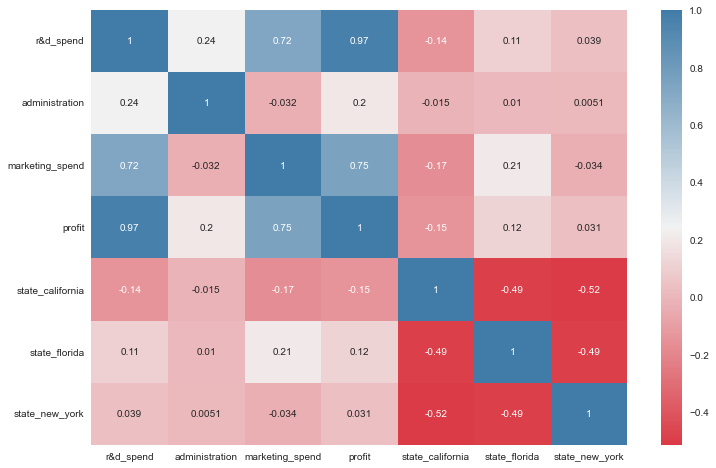

In [551]:
fig = plt.figure(figsize=[12,8])
sns.heatmap(df.corr(), annot=True, cmap = sns.diverging_palette(10, 240, as_cmap = True))
plt.show()

In [552]:
df.corr()['profit'].sort_values(ascending=False)

profit              1.000000
r&d_spend           0.972900
marketing_spend     0.747766
administration      0.200717
state_florida       0.116244
state_new_york      0.031368
state_california   -0.145837
Name: profit, dtype: float64

 - Looking at the correlation analysis, we can see that __r&d_spend__ has the highest correlation with __profit__ (.97); followed by __marketing_spend__ (.75);
 - While the other features don't have strong correlations with __profit__

#### Data Standardization

 - Note: it's best practice to scale the data after the train / test split since doing it before can avoid a biased evaluation; but we'll do it first for this regression
 - In this section, we'll normalize the data points with the Standard Scaler

In [553]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

### When applying standardization after train / test split
## transform training set
# X_train_norm = scaler.fit_transform(X_train, y_train)
# X_train_norm = pd.DataFrame(X_train_norm, columns=X.columns)
# y_train_norm = scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_train_norm = pd.DataFrame(y_train_norm, columns=["profit"])
# y_train_norm = pd.DataFrame(y_train_norm, columns=y.columns)
## transform test set
# X_test_norm = scaler.fit_transform(X_test)
# X_train_norm
# y_train_norm

,r&d_spend,administration,marketing_spend,profit,state_california,state_florida,state_new_york
0,2.016411,0.560753,2.153943,2.011203,-0.717741,-0.685994,1.393261
1,1.955860,1.082807,1.923600,1.999430,1.393261,-0.685994,-0.717741
2,1.754364,-0.728257,1.626528,1.980842,-0.717741,1.457738,-0.717741
3,1.554784,-0.096365,1.422210,1.776627,-0.717741,-0.685994,1.393261
4,1.504937,-1.079919,1.281528,1.357740,-0.717741,1.457738,-0.717741


 - Standard Scaler from scratch (only for r&d_spend)

In [554]:
def standard_scaler_manual(df):
    df = df[["r&d_spend"]]
    mean = float(df.mean())
    n = int(df.count())
    standard_dev = float(np.std(df))
    x_scaled = []
    for index, row in df.iterrows():
        x_scaled_row = (row["r&d_spend"] - mean) / standard_dev
        x_scaled.append(x_scaled_row)
    df["r&d_spend_scaled"] = x_scaled
    return df

df_example_scale = standard_scaler_manual(df)
df_example_scale.head()

,r&d_spend,r&d_spend_scaled
0,165349.20,2.016411
1,162597.70,1.955860
2,153441.51,1.754364
3,144372.41,1.554784
4,142107.34,1.504937


#### Train / Test Split

In [555]:
X = df_scaled.drop(["profit"], axis = 1)
y = df_scaled.profit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(f"Shape of X_train: {X_train.shape}\nShape of y_train: {y_train.shape}")

Shape of X_train: (35, 6)
Shape of y_train: (35,)


## Modeling (Multiple Linear Regression)

#### with statsmodel (OLS)

_In this section we'll evaluate the use of different features for our regression model_


 - Usage of all features

In [556]:
regressor_all = sm.OLS(y_train, X_train).fit()
print(regressor_all.summary())

                                 OLS Regression Results                                
Dep. Variable:                 profit   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              116.2
Date:                Sat, 19 Nov 2022   Prob (F-statistic):                    1.07e-18
Time:                        18:05:36   Log-Likelihood:                          2.2452
No. Observations:                  35   AIC:                                      5.510
Df Residuals:                      30   BIC:                                      13.29
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Notes:
 - __r&d_spend__ is the feature with highest statistical significance (p_value < .05) - we can reject the Null Hypothesis _(that r&s_spend is not statistically siginficant to explain profit)_
 - As for the rest of the features, p_value > .05; so they aren't significant in explaining profit
 - R-squared (.95) & Adjusted R-squared (.94) which indicates a good level of fit with Y (profit); the change in these variables have an effect in the change in profit

Now we'll use only 2 independent variables for the rest of our Regression Model (even if R-squared is lower):
 - r&d_spend
 - marketing_spend

In [557]:
X_train_norm_select = X_train[["r&d_spend", "marketing_spend"]]
X_train_norm_select.head()

,r&d_spend,marketing_spend
6,1.340066,-0.688150
41,-1.008534,-0.384552
46,-1.593413,0.711122
47,-1.622362,-1.743127
15,0.897913,0.419219


In [558]:
const_sl = sm.add_constant(X_train_norm_select)
regressor_sl = sm.OLS(y_train, const_sl).fit()
predict_sl = regressor_sl.predict(const_sl)
print(regressor_sl.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     293.3
Date:                Sat, 19 Nov 2022   Prob (F-statistic):           2.63e-21
Time:                        18:05:36   Log-Likelihood:                 1.3360
No. Observations:                  35   AIC:                             3.328
Df Residuals:                      32   BIC:                             7.994
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0246      0.042     

#### with Sklearn

In [559]:
model_skl = LinearRegression()
model_skl.fit(X_train_norm_select, y_train)


LinearRegression()

In [560]:
print(f"Y-intercept: {model_skl.intercept_}\nSlopes: {model_skl.coef_}")

Y-intercept: -0.024559870397659243
Slopes: [0.88531841 0.11797408]


In [561]:
print(f"Y Predict Formula becomes:\nY = {round(model_skl.intercept_,4)} + (x1 * {round(model_skl.coef_[0],4)}) + (x2 * {round(model_skl.coef_[1],4)})")

Y Predict Formula becomes:
Y = -0.0246 + (x1 * 0.8853) + (x2 * 0.118)


In [562]:
# validation of prediction with SKlearn
rd_spend, mktng_spend = 165000, 385000
print("r&d_spend = $165,000\nmarketing_spend = $385,000")
print(f"Y = {model_skl.predict([[rd_spend, mktng_spend]])}")

r&d_spend = $165,000
marketing_spend = $385,000
Y = [191497.53220332]


#### Manually from scratch

In [576]:
df_scratch = X_train.copy()
df_scratch["profit"] = y_train.tolist()
df_scratch = df_scratch[[
    "r&d_spend",
    "marketing_spend",
    "profit"
]]
df_scratch.head()

,r&d_spend,marketing_spend,profit
6,1.340066,-0.688150,1.105481
41,-1.008534,-0.384552,-0.857466
46,-1.593413,0.711122,-1.566922
47,-1.622362,-1.743127,-1.740627
15,0.897913,0.419219,0.448720


In [577]:
matrix_df = df_scratch.rename(
    columns={"r&d_spend": "x1", "marketing_spend": "x2", "profit": "y"}
)
matrix_df.head()

,x1,x2,y
6,1.340066,-0.688150,1.105481
41,-1.008534,-0.384552,-0.857466
46,-1.593413,0.711122,-1.566922
47,-1.622362,-1.743127,-1.740627
15,0.897913,0.419219,0.448720


In [578]:
matrix_df["x1*y"] = matrix_df["x1"] * matrix_df["y"]
matrix_df["x2*y"] = matrix_df["x2"] * matrix_df["y"]
matrix_df["x1*x2"] = matrix_df["x1"] * matrix_df["x2"]
matrix_df["x1^2"] = matrix_df["x1"] ** 2
matrix_df["x2^2"] = matrix_df["x2"] ** 2
matrix_df.head()

,x1,x2,y,x1*y,x2*y,x1*x2,x1^2,x2^2
6,1.340066,-0.688150,1.105481,1.481417,-0.760736,-0.922167,1.795778,0.473550
41,-1.008534,-0.384552,-0.857466,0.864783,0.329740,0.387834,1.017140,0.147881
46,-1.593413,0.711122,-1.566922,2.496754,-1.114274,-1.133112,2.538966,0.505695
47,-1.622362,-1.743127,-1.740627,2.823927,3.034134,2.827983,2.632059,3.038492
15,0.897913,0.419219,0.448720,0.402911,0.188112,0.376422,0.806248,0.175744


In [579]:
# now sums
data = {
    "Σx1": [matrix_df["x1"].sum()],
    "Σx2": [matrix_df["x2"].sum()],
    "Σy": [matrix_df["y"].sum()],
    "Σx1*y": [matrix_df["x1*y"].sum()],
    "Σx2*y": [matrix_df["x2*y"].sum()],
    "Σx1*x2": [matrix_df["x1*x2"].sum()],
    "Σx1^2": [matrix_df["x1^2"].sum()],
    "Σx2^2": [matrix_df["x2^2"].sum()]
}

n = len(matrix_df["x1"])
regression_matrix = pd.DataFrame(data)
regression_matrix

,Σx1,Σx2,Σy,Σx1*y,Σx2*y,Σx1*x2,Σx1^2,Σx2^2
0,-0.389488,4.428789,-0.681934,35.908262,25.490956,24.610894,37.269358,32.305818


In [580]:
data_reg = {
    "Σx1^2": regression_matrix["Σx1^2"] - ( regression_matrix["Σx1"] ** 2 / n ),
    "Σx2^2": regression_matrix["Σx2^2"] - ( regression_matrix["Σx2"] ** 2 / n ),
    "Σx1*y": regression_matrix["Σx1*y"] - (( regression_matrix["Σx1"] * regression_matrix["Σy"]) / n ),
    "Σx2*y": regression_matrix["Σx2*y"] - (( regression_matrix["Σx2"] * regression_matrix["Σy"]) / n ),
    "Σx1*x2": regression_matrix["Σx1*x2"] - (( regression_matrix["Σx1"] * regression_matrix["Σx2"]) / n )
}

reg_sums = pd.DataFrame(data_reg)
reg_sums

,Σx1^2,Σx2^2,Σx1*y,Σx2*y,Σx1*x2
0,37.265024,31.745413,35.900673,25.577246,24.660179


In [581]:
B1_numerator = ( reg_sums["Σx2^2"] * reg_sums["Σx1*y"] ) - (reg_sums["Σx1*x2"] * reg_sums["Σx2*y"])
B1_denominator = ( reg_sums["Σx1^2"] * reg_sums["Σx2^2"] ) - (reg_sums["Σx1*x2"] ** 2)
B1 = float(B1_numerator / B1_denominator)
print(B1)

0.8853184057130965


In [582]:
B2_numerator = ( reg_sums["Σx1^2"] * reg_sums["Σx2*y"] ) - (reg_sums["Σx1*x2"] * reg_sums["Σx1*y"] )
B2_denominator = ( reg_sums["Σx1^2"] * reg_sums["Σx2^2"] ) - ( reg_sums["Σx1*x2"] ** 2 )
B2 = float(B2_numerator / B2_denominator)
print(B2)

0.11797407745593


In [583]:
B0 = matrix_df["y"].mean() - (B1 * matrix_df["x1"].mean()) - (B2 * matrix_df["x2"].mean())
print(B0)

-0.02455987039765915


In [584]:
def predict_mlr(x1, x2):
    Y = B0 + (B1 * x1) + (B2 * x2)
    print(f"Y = {B0} + ({B1} * x1) + ({B2} * x2)")
    print(Y)

# validate with same x-values done above
predict_mlr(rd_spend, mktng_spend)

Y = -0.02455987039765915 + (0.8853184057130965 * x1) + (0.11797407745593 * x2)
191497.5322033236


### Model Evaluation

##### RMSE

In [570]:
X_test_norm_select = X_test[["r&d_spend", "marketing_spend"]]
mse_test = mean_squared_error(y_test, model_skl.predict(X_test_norm_select))
rmse_test = np.sqrt(mse_test)
mse_train = mean_squared_error(y_train, model_skl.predict(X_train_norm_select))
rmse_train = np.sqrt(mse_train)

print(f"RMSE (train) = {round(rmse_train,4)}")
print(f"RMSE (test) = {round(rmse_test,4)}")

RMSE (train) = 0.2329
RMSE (test) = 0.2044


##### R2 Score (R-squared)

In [571]:
r2_score_train = r2_score(y_train, model_skl.predict(X_train_norm_select))
r2_score_test = r2_score(y_test, model_skl.predict(X_test_norm_select))

print(f"R2 Score (train) = {round(r2_score_train,4)}")
print(f"R2 Score (test) = {round(r2_score_test,4)}")

R2 Score (train) = 0.9483
R2 Score (test) = 0.9527


 - __Note__: here we are __NOT__ trying to fine tune the model by only cherry picking the variable(s) with highest statistical significance (e.g. p_value < .05) & coming up with the "best" model;
 - instead we're interested in showing the specific questions about how different independent variables are related to Y (profit)
 - __R-squared scores__ are still high for both cases when using all independent variables or only 2 _(e.g. r&d_spend & marketing_spend)_

Sources:
 - Calculate Multiple Linear Regression by hand (2 independent variables): https://www.statology.org/multiple-linear-regression-by-hand/